In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

ModuleNotFoundError: No module named 'numpy'

Original dataset shape: (366,)
Original dataset distribution:
 RainTomorrow
0    300
1     66
Name: count, dtype: int64

Resampled dataset shape: (600,)
Resampled dataset distribution:
 RainTomorrow
1    300
0    300
Name: count, dtype: int64


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5, 128)         │        69,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 5, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 221,857 (866.63 KB)

 Trainable params: 221,857 (866.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.4676 - loss: 0.6934 - val_accuracy: 0.6458 - val_loss: 0.6824
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6981 - loss: 0.6713 - val_accuracy: 0.7500 - val_loss: 0.6316
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7130 - loss: 0.6103 - val_accuracy: 0.7708 - val_loss: 0.5729
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7231 - loss: 0.5580 - val_accuracy: 0.6875 - val_loss: 0.6080
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7188 - loss: 0.5648 - val_accuracy: 0.7708 - val_loss: 0.5819
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7414 - loss: 0.5426 - val_accuracy: 0.7708 - val_loss: 0.5796
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7362 - loss: 0.5704 - val_accuracy: 0.7917 - val_loss: 0.5729
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7214 - loss: 0.5392 - val_accuracy: 0.

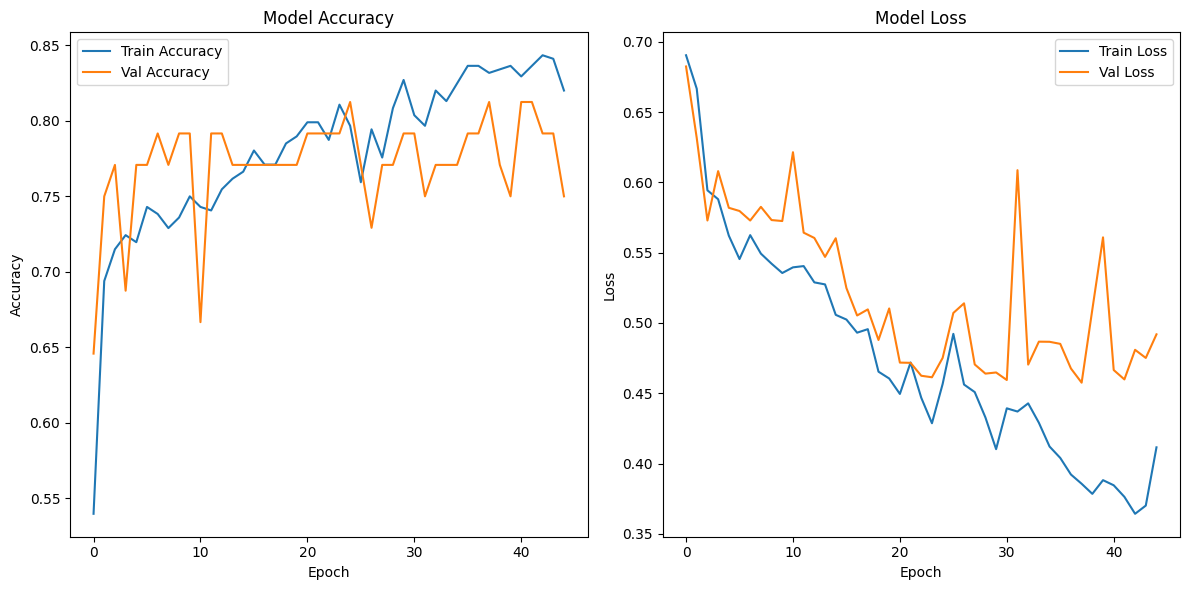


Probability of rain tomorrow: 98.55%
Prediction: It will rain tomorrow


In [ ]:


# Constants
SEQUENCE_LENGTH = 5
BATCH_SIZE = 32
EPOCHS = 100
VALIDATION_SPLIT = 0.1
PATIENCE = 7
CSV_PATH = Path("/content/weather.csv")

# Load and preprocess data
def load_and_preprocess_data(csv_path):
    """
    Loads and preprocesses weather data from a CSV file.

    Args:
        csv_path (Path): The path to the CSV file.

    Returns:
        tuple: A tuple containing:
            - X_scaled (np.ndarray): Scaled features.
            - y (np.ndarray): Target values.
            - features (list): List of feature names.
            - scaler (MinMaxScaler): Fitted MinMaxScaler object.
            - wind_dir_encoder (LabelEncoder): Fitted LabelEncoder object for WindGustDir.
    """
    data = pd.read_csv(csv_path)
    # Handle missing values using ffill method
    data.ffill(inplace=True)

    # Encode categorical and binary targets
    wind_dir_encoder = LabelEncoder()
    data['WindGustDir'] = wind_dir_encoder.fit_transform(data['WindGustDir'])
    # Handle potential missing values in RainTomorrow after ffill
    data.dropna(subset=['RainTomorrow'], inplace=True)
    data['RainTomorrow'] = data['RainTomorrow'].map({'No': 0, 'Yes': 1})

    features = ['MinTemp', 'MaxTemp', 'WindGustDir', 'WindGustSpeed', 'Humidity', 'Pressure', 'Temp']
    target = 'RainTomorrow'

    X = data[features]
    y = data[target]

    # Apply SMOTE to handle class imbalance
    print("Original dataset shape:", y.shape)
    print("Original dataset distribution:\n", pd.Series(y).value_counts())
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    print("\nResampled dataset shape:", y_resampled.shape)
    print("Resampled dataset distribution:\n", pd.Series(y_resampled).value_counts())

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_resampled)  # Scale resampled data

    return X_scaled, y_resampled.values, features, scaler, wind_dir_encoder # Return resampled data

# Create sequences for LSTM
def create_sequences(X, y, seq_len=SEQUENCE_LENGTH):
    """
    Creates sequences of data for the LSTM model.

    Args:
        X (np.ndarray): Features data.
        y (np.ndarray): Target values.
        seq_len (int): The length of each sequence.

    Returns:
        tuple: A tuple containing:
            - X_seq (np.ndarray): Feature sequences.
            - y_seq (np.ndarray): Target values for each sequence.
    """
    X_seq = [X[i:i+seq_len] for i in range(len(X) - seq_len)]
    y_seq = [y[i+seq_len] for i in range(len(X) - seq_len)]
    return np.array(X_seq), np.array(y_seq)


# Build the LSTM model
def build_lstm_model(input_shape):
    """
    Builds a Sequential LSTM model.

    Args:
        input_shape (tuple): The shape of the input sequences (sequence_length, num_features).

    Returns:
        tensorflow.keras.models.Sequential: The built LSTM model.
    """
    model = Sequential([
        Input(shape=input_shape), # Use Input layer to specify input shape
        LSTM(128, return_sequences=True),
        Dropout(0.3),
        LSTM(128, return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Plot training history
def plot_history(history):
    """
    Plots the training and validation accuracy and loss history.

    Args:
        history (tensorflow.keras.callbacks.History): The training history object.
    """
    plt.figure(figsize=(12, 6))
    for i, metric in enumerate(['accuracy', 'loss']):
        plt.subplot(1, 2, i + 1)
        plt.plot(history.history[metric], label=f'Train {metric.capitalize()}')
        plt.plot(history.history[f'val_{metric}'], label=f'Val {metric.capitalize()}')
        plt.title(f'Model {metric.capitalize()}')
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.legend()
    plt.tight_layout()
    plt.show()

# Predict for current weather
def predict_current_weather(model, scaler, encoder, current_data, last_sequence, features):
    """
    Predicts the probability of rain tomorrow for the current weather data.

    Args:
        model (tensorflow.keras.models.Sequential): The trained LSTM model.
        scaler (MinMaxScaler): The fitted MinMaxScaler object.
        encoder (LabelEncoder): The fitted LabelEncoder object for WindGustDir.
        current_data (dict): A dictionary containing the current weather data.
        last_sequence (np.ndarray): The last sequence from the training data for context.
        features (list): List of feature names.

    Returns:
        float: The predicted probability of rain tomorrow.
    """
    # Ensure WindGustDir is encoded if it's a string
    if isinstance(current_data['WindGustDir'], str):
        current_data['WindGustDir'] = encoder.transform([current_data['WindGustDir']])[0]
    elif isinstance(current_data['WindGustDir'], (int, np.integer)):
        # If it's already encoded, keep it as is.
        pass
    else:
        # Handle unexpected types if necessary
        raise TypeError("WindGustDir must be a string or encoded integer.")


    df = pd.DataFrame([current_data], columns=features)
    current_scaled = scaler.transform(df)

    # Create the sequence for prediction
    sequence = np.copy(last_sequence)
    sequence[:-1] = sequence[1:] # Shift existing sequence data
    sequence[-1] = current_scaled[0] # Add current weather data to the end

    sequence = sequence.reshape(1, SEQUENCE_LENGTH, len(features))

    return model.predict(sequence, verbose=0)[0][0]

# Main execution
X_scaled, y, features, scaler, encoder = load_and_preprocess_data(CSV_PATH)
X_seq, y_seq = create_sequences(X_scaled, y)

# Split the data with shuffling to ensure both classes are in the test set
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42, shuffle=True, stratify=y_seq)


model = build_lstm_model(input_shape=(SEQUENCE_LENGTH, len(features)))
model.summary()

early_stop = EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    validation_split=VALIDATION_SPLIT,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop],
    verbose=1
)

# Evaluation
y_pred = (model.predict(X_test, verbose=0) > 0.5).astype(int)
print("\nModel Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:")
# Handle zero division in classification report
print(classification_report(y_test, y_pred, zero_division=0))


# Plot training history
plot_history(history)

# Predict for a sample current weather
current_weather = {
    'MinTemp': 15.2,
    'MaxTemp': 25.1,
    'WindGustDir': 'E', # Keep as string for demonstration
    'WindGustSpeed': 46,
    'Humidity': 42,
    'Pressure': 1015,
    'Temp': 23.9
}

# Use last SEQUENCE_LENGTH rows of the original scaled data to form initial context for prediction
# Note: It's generally better to use a sliding window approach for real-time predictions
# where you maintain the last SEQUENCE_LENGTH actual weather observations.
# For this example, we'll use the last part of the preprocessed data as context.
last_sequence_context = X_scaled[len(X_scaled) - len(X_seq) - SEQUENCE_LENGTH : len(X_scaled) - len(X_seq)]


rain_prob = predict_current_weather(model, scaler, encoder, current_weather, last_sequence_context, features)


print(f"\nProbability of rain tomorrow: {rain_prob:.2%}")
print("Prediction:", "It will rain tomorrow" if rain_prob > 0.5 else "It will NOT rain tomorrow")